## TODO:

- [fast.ai solution 1.1](https://forums.fast.ai/t/share-your-work-here/27676/747)
- [fast.ai solution 1.2](https://github.com/martin-merener/deep_learning/blob/master/more_transfer_learning/more_transfer_learning_skincancer.ipynb)

## Deal with imbance
- [Weights in loss function](https://forums.fast.ai/t/how-to-use-class-weights-in-loss-function-for-imbalanced-dataset/19589/6)

In [1]:
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from fastai.vision import *

# Data

In [2]:
path     = pathlib.Path("E:/Datasets/TFM/ISIC-2017")

df_train = pd.read_csv(path / "ground_truth_train.csv")
df_valid = pd.read_csv(path / "ground_truth_valid.csv")
df_test  = pd.read_csv(path / "ground_truth_test.csv")
df_train[["melanoma", "seborrheic_keratosis"]] = df_train[["melanoma", "seborrheic_keratosis"]].astype(int)
df_valid[["melanoma", "seborrheic_keratosis"]] = df_valid[["melanoma", "seborrheic_keratosis"]].astype(int)
df_test[ ["melanoma", "seborrheic_keratosis"]] = df_test[ ["melanoma", "seborrheic_keratosis"]].astype(int)

df_train_meta = pd.read_csv(path / "data_train" / "ISIC-2017_Training_Data_metadata.csv")
df_valid_meta = pd.read_csv(path / "data_valid" / "ISIC-2017_Validation_Data_metadata.csv")
df_valid_meta = pd.read_csv(path / "data_test"  / "ISIC-2017_Test_v2_Data_metadata.csv")

df_train.head()

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0,0
1,ISIC_0000001,0,0
2,ISIC_0000002,1,0
3,ISIC_0000003,0,0
4,ISIC_0000004,1,0


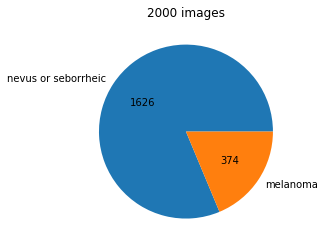

In [3]:
pct = lambda p: '{:.0f}'.format(p * 2000 / 100)
labels = ["nevus or seborrheic", 'melanoma']
df_train['melanoma'].value_counts().plot.pie(labels=labels, autopct=pct); plt.ylabel(''); plt.title('2000 images');

In [4]:
###################################### Stratified 10 Fold Cross validation indexes
n_cv_folds = 10
x = df_train.image_id.values
y = df_train.melanoma.values
train_idxs_fold = []
valid_idxs_fold = []

cross_valid = StratifiedKFold(n_splits=n_cv_folds, shuffle=True, random_state=0) # Always same random stratified CV
for i, (train_index, valid_index) in enumerate(cross_valid.split(x, y)):
    train_idxs_fold.append(train_index)
    valid_idxs_fold.append(valid_index)
    
##################################### Src data
src_train = ImageList.from_df(df_train, path, folder='data_train', suffix=".jpg")
src_valid = ImageList.from_df(df_valid, path, folder='data_valid', suffix=".jpg")
src_test  = ImageList.from_df(df_test,  path, folder='data_test',  suffix=".jpg")

data = (src_train.split_by_idxs(train_idxs_fold[0], valid_idxs_fold[0]) # src_train.no_split(); src.valid = valid
        .label_from_df(cols='melanoma')
        .transform(get_transforms(flip_vert=True, max_warp=None), size=512)
        .databunch(bs=16)
        .normalize(imagenet_stats))

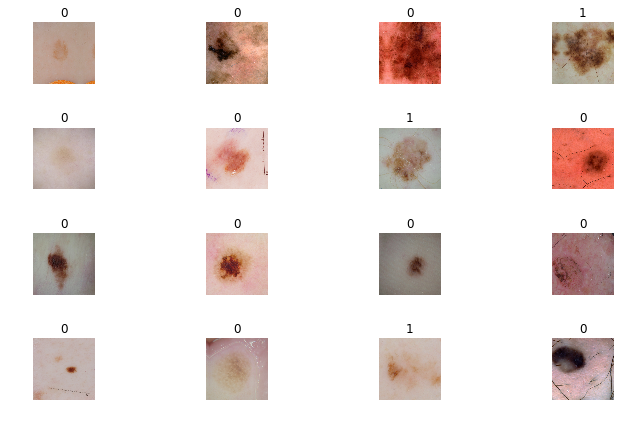

In [5]:
data.show_batch(rows=4, figsize=(10,6))

# Train

In [6]:
##################################################### Fastai AUC ROC chapuza
def auroc_score(input, target):
    input, target = input.cpu().numpy()[:,1], target.cpu().numpy()
    return metrics.roc_auc_score(target, input)

class AUROC(Callback):
    _order = -20 #Needs to run before the recorder

    def __init__(self, learn, **kwargs): self.learn = learn
    def on_train_begin(self, **kwargs): self.learn.recorder.add_metric_names(['AUROC'])
    def on_epoch_begin(self, **kwargs): self.output, self.target = [], []
    
    def on_batch_end(self, last_target, last_output, train, **kwargs):
        if not train:
            self.output.append(last_output)
            self.target.append(last_target)
                
    def on_epoch_end(self, last_target, last_output, **kwargs):
        if len(self.output) > 0:
            output = torch.cat(self.output)
            target = torch.cat(self.target)
            preds = F.softmax(output, dim=1)
            metric = auroc_score(preds, target)
            self.learn.recorder.add_metrics([metric])

https://forums.fast.ai/t/lesson-1-notebook-stuck-in-create-cnn/37486/4

In [7]:
def _resnet_split(m:nn.Module): return (m[0][6],m[1])
def my_create_cnn(data:DataBunch, arch:Callable, num_features:int, cut:Union[int,Callable]=None, pretrained:bool=True, lin_ftrs:Optional[Collection[int]]=None, ps:Floats=0.5,
                custom_head:Optional[nn.Module]=None, split_on:Optional[SplitFuncOrIdxList]=None,
                bn_final:bool=False, **learn_kwargs:Any)->Learner:
    body = create_body(arch, pretrained, cut)
    head = custom_head or create_head(num_features, data.c, lin_ftrs, ps=ps, bn_final=bn_final)
    model = nn.Sequential(body, head)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, _resnet_split))
    if pretrained: learn.freeze()
    apply_init(model[1], nn.init.kaiming_normal_)
    return learn
# where num_features=1024 for resnet34, 4096 for resnet50 and 1024 for resnet18

In [10]:
arch   = models.resnet34 # models.resnet50
#acc_02 = partial(accuracy_thresh, thresh=0.2)
#f_score = partial(fbeta, thresh=0.2)

#learn = create_cnn(data, arch, metrics=accuracy, callback_fns=AUROC)
learn = my_create_cnn(data, models.resnet18, 1024, metrics=[accuracy], callback_fns=AUROC)

########################################### Balanced loss function
#   [healthy=1626,  melanomas=374]
weights1 = [1/1626,   1/374]      # [0.0006, 0.0027]
weights2 = [374/2000, 1626/2000]  # [0.187,  0.813]
#c_counts = np.bincount(data.train_ds.y.items)
#weights1 = 1/class_counts
#weights2 = sum(class_counts)/class_counts
weights  = torch.FloatTensor(weights2).cuda()

learn.loss_func = CrossEntropyFlat(weight=weights)

#print(learn.summary())

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


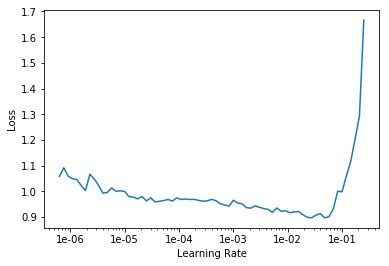

In [11]:
learn.lr_find()
learn.recorder.plot()

In [13]:
learn.fit_one_cycle(3, 1e-2)

epoch,train_loss,valid_loss,accuracy,AUROC,time
1,0.875009,1.266718,0.706468,0.530352,04:20
2,0.780531,0.722017,0.741294,0.711172,04:09
3,0.649686,0.595131,0.726368,0.746206,04:03


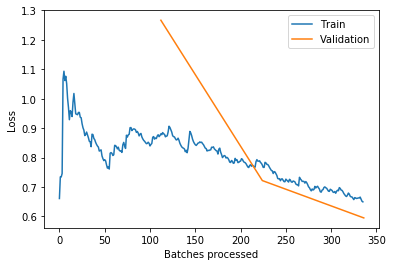

In [14]:
learn.recorder.plot_losses()

In [17]:
learn.save("resnet34freezed")

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


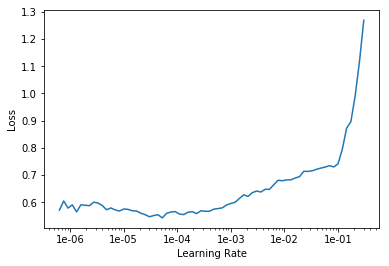

In [18]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(3, 1e-5)

epoch,train_loss,valid_loss,accuracy,AUROC,time
1,0.580499,0.588695,0.721393,0.750565,04:23
2,0.565366,0.582483,0.746269,0.769293,04:21
3,0.562768,0.568394,0.751244,0.779625,04:17


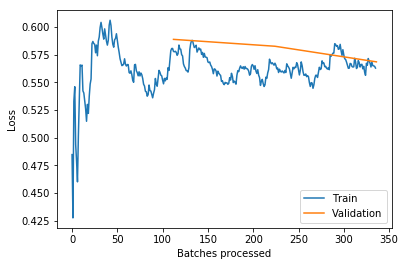

In [20]:
learn.recorder.plot_losses()

In [21]:
learn.save("resnet34unfreezed")

# Results

In [22]:
learn.load("resnet34unfreezed")
preds,    y    = learn.get_preds()
preds = preds[:,1].numpy()
y     = y.numpy()

In [23]:
def plot_roc(y_valid, y_pred, ax=None, figsize=(5,5)):

    if ax is None: fig, ax = plt.subplots(1, 1, figsize=figsize)
    
    fpr, tpr, threshold = metrics.roc_curve(y_valid, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    ax.set_title('ROC Curve')
    ax.plot(fpr, tpr, 'darkorange', label = 'AUC = %0.4f' % roc_auc)
    ax.legend(loc = 'lower right', fontsize="large")
    ax.plot([0, 1], [0, 1], color='navy', linestyle='--')
    ax.set_xlim([-0.005, 1])
    ax.set_ylim([0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    return ax

Accuracy:  0.7512437810945274
AUC ROC:   0.7796254439780432
F1 score:  0.47916666666666674
Precision: 0.39655172413793105
Recall:    0.6052631578947368
Confusion matrix:
 [[128  35]
 [ 15  23]]


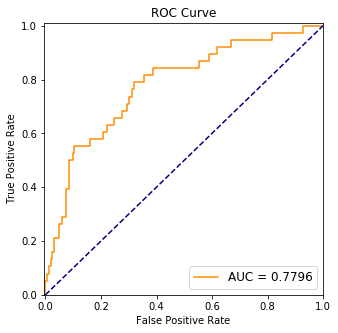

In [24]:
print("Accuracy: ", metrics.accuracy_score(y, preds.round()))
print("AUC ROC:  ", metrics.roc_auc_score(y, preds))
print("F1 score: ", metrics.f1_score(y, preds.round()))
print("Precision:", metrics.precision_score(y, preds.round()))
print("Recall:   ", metrics.recall_score(y, preds.round()))
print("Confusion matrix:\n", metrics.confusion_matrix(y, preds.round()))
plot_roc(y, preds);

In [26]:
weights  = torch.FloatTensor(weights2)

learn.loss_func = CrossEntropyFlat(weight=weights)

In [27]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

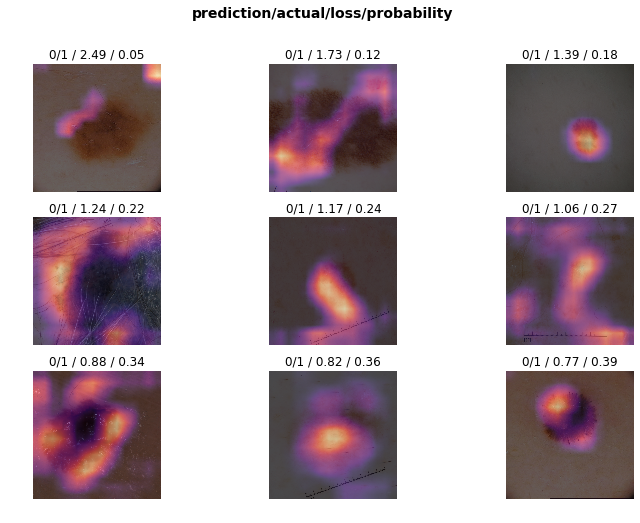

In [29]:
interp.plot_top_losses(9, figsize=(12,8))

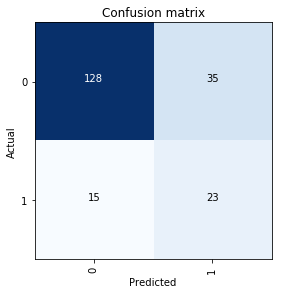

In [28]:
interp.plot_confusion_matrix()

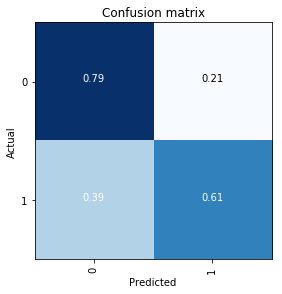

In [31]:
interp.plot_confusion_matrix(normalize=True)

In [30]:
interp.most_confused(min_val=2)

[(0, 1, 35), (1, 0, 15)]